## Import Libraries

In [14]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

## Load Data and Models

In [15]:
# Load data
users = pd.read_csv("../data/raw/users.csv")
programs = pd.read_csv("../data/raw/programs.csv")
interactions = pd.read_csv("../data/raw/interactions.csv")

print(f"Total data: {len(users)} users, {len(programs)} programs, {len(interactions)} interactions")

# Split interactions into 80% train and 20% test
from sklearn.model_selection import train_test_split

train_interactions, test_interactions = train_test_split(
    interactions, 
    test_size=0.2, 
    random_state=42
    # Note: Not using stratify due to small dataset with 100 users
)

print(f"\nTrain/Test Split:")
print(f"  Training: {len(train_interactions)} interactions ({len(train_interactions)/len(interactions)*100:.1f}%)")
print(f"  Testing:  {len(test_interactions)} interactions ({len(test_interactions)/len(interactions)*100:.1f}%)")

Total data: 500 users, 50 programs, 8004 interactions

Train/Test Split:
  Training: 6403 interactions (80.0%)
  Testing:  1601 interactions (20.0%)


## Create Ground Truth (Train and Test)

For proper evaluation, we use training data to build models and test data to evaluate them.

In [16]:
# Create ground truth from TRAINING data (for model building)
train_ground_truth = defaultdict(set)
for _, row in train_interactions.iterrows():
    if row["interaction"] == 1:  # Only positive interactions
        train_ground_truth[row["user_id"]].add(row["program_id"])

# Create ground truth from TESTING data (for evaluation)
test_ground_truth = defaultdict(set)
for _, row in test_interactions.iterrows():
    if row["interaction"] == 1:  # Only positive interactions
        test_ground_truth[row["user_id"]].add(row["program_id"])

print(f"Testing ground truth: {len(test_ground_truth)} users")
print(f"Avg test interactions per user: {np.mean([len(v) for v in test_ground_truth.values()]):.2f}")

Testing ground truth: 483 users
Avg test interactions per user: 3.31


## Load Pre-trained Models

Load models that were trained on training data (80%) in notebooks 02 and 03.

In [17]:
import joblib

# Load content-based model (trained on all programs)
tfidf_vectorizer = joblib.load("../models/tfidf.pkl")
tfidf_matrix = joblib.load("../models/program_tfidf.pkl")

# Load CF model (trained on 80% training interactions)
cf_model = joblib.load("../models/cf_svd.pkl")
predicted_scores = cf_model["predicted_scores"]
user_id_map = cf_model["user_id_map"]
reverse_item_map = cf_model["reverse_item_map"]
interaction_matrix = cf_model["interaction_matrix"]

print("✓ Pre-trained models loaded successfully")
print(f"  - TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"  - CF predicted scores shape: {predicted_scores.shape}")

✓ Pre-trained models loaded successfully
  - TF-IDF matrix shape: (50, 177)
  - CF predicted scores shape: (500, 50)


## Recommendation Functions

Define the three recommendation approaches for evaluation.

In [18]:
def recommend_content_based(user_interests, k=5):
    """Content-based recommendations"""
    user_vector = tfidf_vectorizer.transform([user_interests])
    similarities = cosine_similarity(user_vector, tfidf_matrix).flatten()
    top_indices = np.argsort(similarities)[::-1][:k]
    return [programs.iloc[i]["program_id"] for i in top_indices]

def recommend_cf(user_id, k=5):
    """Collaborative filtering recommendations"""
    if user_id not in user_id_map:
        return []  # Cold-start
    
    user_idx = user_id_map[user_id]
    scores = predicted_scores[user_idx]
    
    # Filter out already-interacted programs
    interacted_items = interaction_matrix[user_idx].nonzero()[1]
    scores_copy = scores.copy()
    scores_copy[interacted_items] = -np.inf
    
    top_items = np.argsort(scores_copy)[::-1][:k]
    return [reverse_item_map[i] for i in top_items]

def recommend_hybrid(user_id, user_interests, k=5, content_weight=0.6, cf_weight=0.4):
    """Hybrid recommendations"""
    # Get content-based scores
    user_vector = tfidf_vectorizer.transform([user_interests])
    content_scores = cosine_similarity(user_vector, tfidf_matrix).flatten()
    content_scores = content_scores / (content_scores.max() if content_scores.max() > 0 else 1)
    
    # Get CF scores (if available)
    combined_scores = {}
    
    if user_id in user_id_map:
        user_idx = user_id_map[user_id]
        cf_scores = predicted_scores[user_idx]
        
        # Normalize CF scores
        valid_scores = cf_scores[cf_scores > -np.inf]
        if len(valid_scores) > 0:
            min_score, max_score = valid_scores.min(), valid_scores.max()
            score_range = max_score - min_score if max_score > min_score else 1
            cf_scores_norm = (cf_scores - min_score) / score_range
        else:
            cf_scores_norm = cf_scores
        
        # Combine scores
        for i, program_id in enumerate(programs["program_id"]):
            if program_id in reverse_item_map.values():
                item_idx = [k for k, v in reverse_item_map.items() if v == program_id][0]
                combined_scores[program_id] = content_weight * content_scores[i] + cf_weight * cf_scores_norm[item_idx]
            else:
                combined_scores[program_id] = content_weight * content_scores[i]
    else:
        # Cold-start: use only content-based
        for i, program_id in enumerate(programs["program_id"]):
            combined_scores[program_id] = content_scores[i]
    
    # Sort and return top-k
    sorted_programs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    return [p[0] for p in sorted_programs]

print("✓ Recommendation functions defined")

✓ Recommendation functions defined


## Evaluation Metrics Implementation

In [19]:
def precision_at_k(recommended, relevant, k):
    """Precision@k: fraction of recommended items that are relevant"""
    recommended_k = recommended[:k]
    relevant_count = len(set(recommended_k) & relevant)
    return relevant_count / k if k > 0 else 0

def recall_at_k(recommended, relevant, k):
    """Recall@k: fraction of relevant items that are recommended"""
    recommended_k = recommended[:k]
    relevant_count = len(set(recommended_k) & relevant)
    return relevant_count / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(recommended, relevant, k):
    """NDCG@k: Normalized Discounted Cumulative Gain"""
    recommended_k = recommended[:k]
    
    # DCG: sum of (relevance / log2(position + 1))
    dcg = 0
    for i, item in enumerate(recommended_k):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)  # +2 because positions start at 1
    
    # IDCG: ideal DCG (if all relevant items were at the top)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
    
    return dcg / idcg if idcg > 0 else 0

print("✓ Metrics implemented")

✓ Metrics implemented


## Evaluate All Three Approaches

In [20]:
# Evaluation parameters
K_VALUES = [1, 3, 5]

# Store results
results = {
    "content_based": {k: {"precision": [], "recall": [], "ndcg": []} for k in K_VALUES},
    "collaborative": {k: {"precision": [], "recall": [], "ndcg": []} for k in K_VALUES},
    "hybrid": {k: {"precision": [], "recall": [], "ndcg": []} for k in K_VALUES}
}

# Track coverage (which programs get recommended)
coverage = {
    "content_based": set(),
    "collaborative": set(),
    "hybrid": set()
}

# Evaluate on users who have test interactions
test_user_ids = test_ground_truth.keys()
test_users = users[users["user_id"].isin(test_user_ids)]

print(f"Evaluating on {len(test_users)} users with test interactions\n")

for _, user in test_users.iterrows():
    user_id = user["user_id"]
    user_interests = user["interests_text"]
    
    # Get ground truth from TEST set (unseen data)
    relevant = test_ground_truth.get(user_id, set())
    
    if len(relevant) == 0:
        continue  # Skip users with no test interactions
    
    # Get recommendations from all three approaches
    content_recs = recommend_content_based(user_interests, k=max(K_VALUES))
    cf_recs = recommend_cf(user_id, k=max(K_VALUES))
    hybrid_recs = recommend_hybrid(user_id, user_interests, k=max(K_VALUES))
    
    # Update coverage
    coverage["content_based"].update(content_recs)
    coverage["collaborative"].update(cf_recs)
    coverage["hybrid"].update(hybrid_recs)
    
    # Calculate metrics for each k
    for k in K_VALUES:
        # Content-based
        results["content_based"][k]["precision"].append(precision_at_k(content_recs, relevant, k))
        results["content_based"][k]["recall"].append(recall_at_k(content_recs, relevant, k))
        results["content_based"][k]["ndcg"].append(ndcg_at_k(content_recs, relevant, k))
        
        # Collaborative filtering
        if len(cf_recs) > 0:
            results["collaborative"][k]["precision"].append(precision_at_k(cf_recs, relevant, k))
            results["collaborative"][k]["recall"].append(recall_at_k(cf_recs, relevant, k))
            results["collaborative"][k]["ndcg"].append(ndcg_at_k(cf_recs, relevant, k))
        
        # Hybrid
        results["hybrid"][k]["precision"].append(precision_at_k(hybrid_recs, relevant, k))
        results["hybrid"][k]["recall"].append(recall_at_k(hybrid_recs, relevant, k))
        results["hybrid"][k]["ndcg"].append(ndcg_at_k(hybrid_recs, relevant, k))

print(f"✓ Evaluation completed on {len(test_users)} test users (with unseen interactions)")


Evaluating on 483 users with test interactions

✓ Evaluation completed on 483 test users (with unseen interactions)


## Results Summary

In [21]:
# Calculate average metrics
summary = []

for approach in ["content_based", "collaborative", "hybrid"]:
    for k in K_VALUES:
        avg_precision = np.mean(results[approach][k]["precision"])
        avg_recall = np.mean(results[approach][k]["recall"])
        avg_ndcg = np.mean(results[approach][k]["ndcg"])
        
        summary.append({
            "Approach": approach.replace("_", " ").title(),
            "k": k,
            "Precision@k": f"{avg_precision:.3f}",
            "Recall@k": f"{avg_recall:.3f}",
            "NDCG@k": f"{avg_ndcg:.3f}"
        })

results_df = pd.DataFrame(summary)
print("\n" + "="*70)
print("RECOMMENDATION SYSTEM EVALUATION RESULTS")
print("="*70 + "\n")
print(results_df.to_string(index=False))
print("\n" + "="*70)


RECOMMENDATION SYSTEM EVALUATION RESULTS

     Approach  k Precision@k Recall@k NDCG@k
Content Based  1       0.236    0.074  0.236
Content Based  3       0.186    0.168  0.212
Content Based  5       0.169    0.262  0.239
Collaborative  1       0.151    0.043  0.151
Collaborative  3       0.121    0.106  0.136
Collaborative  5       0.118    0.180  0.160
       Hybrid  1       0.128    0.038  0.128
       Hybrid  3       0.116    0.105  0.129
       Hybrid  5       0.110    0.170  0.149



## Coverage Analysis

Coverage measures what percentage of programs get recommended across all users.

In [22]:
total_programs = len(programs)

print("\nCOVERAGE ANALYSIS")
print("="*50)
for approach, recommended_programs in coverage.items():
    coverage_pct = len(recommended_programs) / total_programs * 100
    print(f"{approach.replace('_', ' ').title():20s}: {len(recommended_programs)}/{total_programs} programs ({coverage_pct:.1f}%)")
print("="*50)


COVERAGE ANALYSIS
Content Based       : 50/50 programs (100.0%)
Collaborative       : 50/50 programs (100.0%)
Hybrid              : 50/50 programs (100.0%)


## Visualization: Metrics Comparison

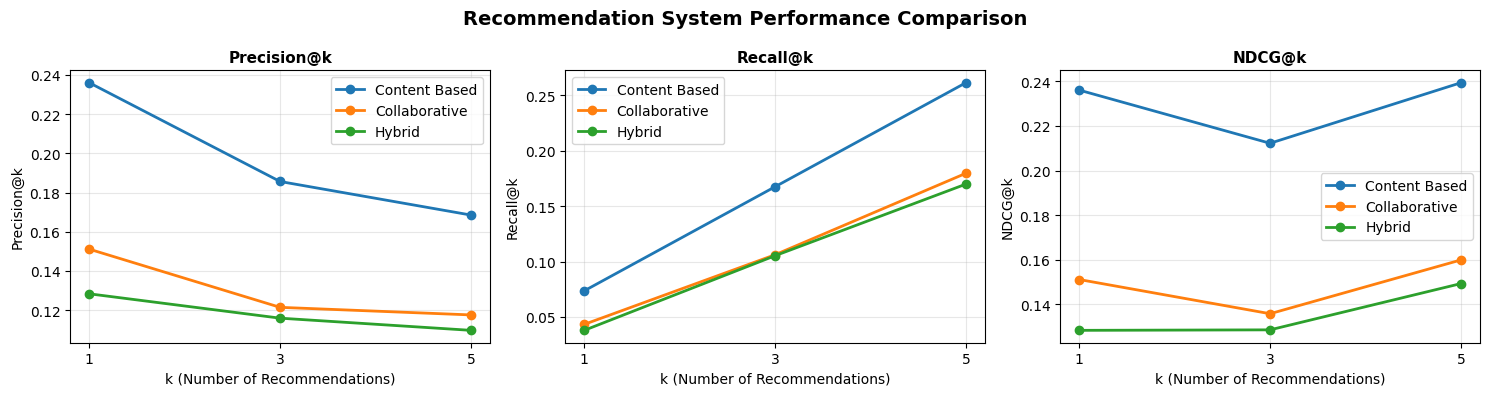

✓ Visualization saved to ../models/evaluation_metrics.png


In [23]:
# Prepare data for plotting
metrics = ["Precision@k", "Recall@k", "NDCG@k"]
approaches = ["Content Based", "Collaborative", "Hybrid"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Recommendation System Performance Comparison", fontsize=14, fontweight='bold')

for idx, metric in enumerate(["precision", "recall", "ndcg"]):
    ax = axes[idx]
    
    for approach_key, approach_name in zip(["content_based", "collaborative", "hybrid"], approaches):
        values = [np.mean(results[approach_key][k][metric]) for k in K_VALUES]
        ax.plot(K_VALUES, values, marker='o', label=approach_name, linewidth=2)
    
    ax.set_xlabel('k (Number of Recommendations)', fontsize=10)
    ax.set_ylabel(metrics[idx], fontsize=10)
    ax.set_title(metrics[idx], fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(K_VALUES)

plt.tight_layout()
plt.savefig("../models/evaluation_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to ../models/evaluation_metrics.png")

## Bar Chart: Approach Comparison at k=3

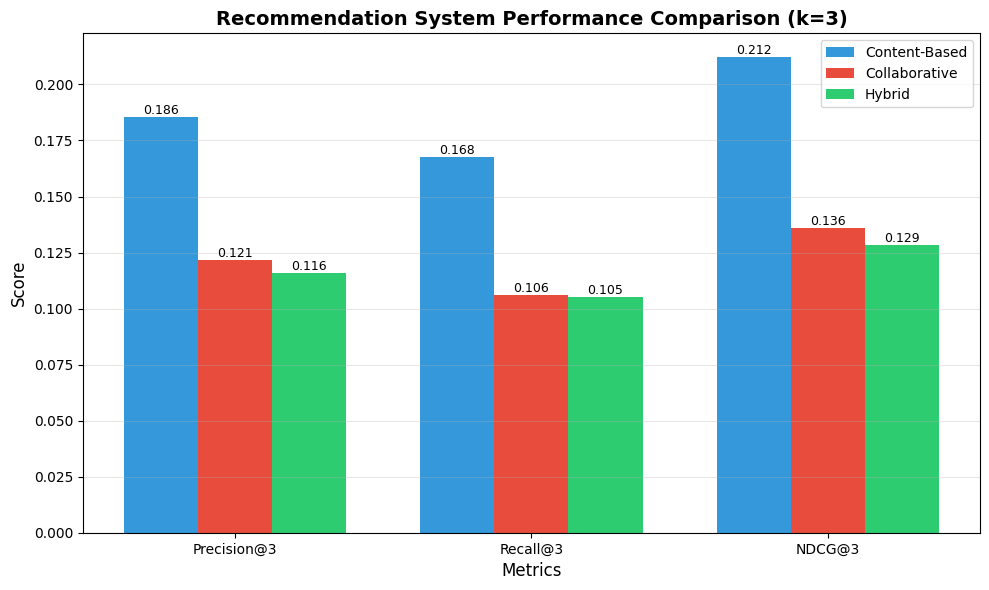

✓ Comparison chart saved to ../models/evaluation_comparison.png


In [24]:
k = 3
metric_names = ['Precision', 'Recall', 'NDCG']
metric_keys = ['precision', 'recall', 'ndcg']

# Prepare data
content_values = [np.mean(results["content_based"][k][m]) for m in metric_keys]
cf_values = [np.mean(results["collaborative"][k][m]) for m in metric_keys]
hybrid_values = [np.mean(results["hybrid"][k][m]) for m in metric_keys]

x = np.arange(len(metric_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, content_values, width, label='Content-Based', color='#3498db')
bars2 = ax.bar(x, cf_values, width, label='Collaborative', color='#e74c3c')
bars3 = ax.bar(x + width, hybrid_values, width, label='Hybrid', color='#2ecc71')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Recommendation System Performance Comparison (k={k})', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{m}@{k}" for m in metric_names])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("../models/evaluation_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison chart saved to ../models/evaluation_comparison.png")

## Key Findings and Analysis

In [25]:
# Determine best approach for each metric at k=3
k = 3
best_approaches = {}

for metric in ["precision", "recall", "ndcg"]:
    scores = {
        "Content-Based": np.mean(results["content_based"][k][metric]),
        "Collaborative": np.mean(results["collaborative"][k][metric]),
        "Hybrid": np.mean(results["hybrid"][k][metric])
    }
    best_approaches[metric] = max(scores, key=scores.get)

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"\n📊 Best Approach by Metric (k={k}):")
print(f"   • Precision@{k}: {best_approaches['precision']}")
print(f"   • Recall@{k}: {best_approaches['recall']}")
print(f"   • NDCG@{k}: {best_approaches['ndcg']}")

print(f"\n📈 Coverage:")
for approach in ["content_based", "collaborative", "hybrid"]:
    pct = len(coverage[approach]) / total_programs * 100
    print(f"   • {approach.replace('_', ' ').title()}: {pct:.1f}% of programs recommended")

print("\n💡 Interpretation:")
print("   • Higher precision = More accurate recommendations")
print("   • Higher recall = Better at finding all relevant programs")
print("   • Higher NDCG = Better ranking quality (relevant items at top)")
print("   • Higher coverage = More diversity in recommendations")
print("\n" + "="*70)


KEY FINDINGS

📊 Best Approach by Metric (k=3):
   • Precision@3: Content-Based
   • Recall@3: Content-Based
   • NDCG@3: Content-Based

📈 Coverage:
   • Content Based: 100.0% of programs recommended
   • Collaborative: 100.0% of programs recommended
   • Hybrid: 100.0% of programs recommended

💡 Interpretation:
   • Higher precision = More accurate recommendations
   • Higher recall = Better at finding all relevant programs
   • Higher NDCG = Better ranking quality (relevant items at top)
   • Higher coverage = More diversity in recommendations



## Save Evaluation Results

In [26]:
# Save results to CSV
results_df.to_csv("../models/evaluation_results.csv", index=False)
print("✓ Results saved to ../models/evaluation_results.csv")

# Save detailed metrics
evaluation_summary = {
    "results": results,
    "coverage": {k: list(v) for k, v in coverage.items()},
    "best_approaches": best_approaches,
    "k_values": K_VALUES
}

joblib.dump(evaluation_summary, "../models/evaluation_summary.pkl")
print("✓ Detailed evaluation saved to ../models/evaluation_summary.pkl")

✓ Results saved to ../models/evaluation_results.csv
✓ Detailed evaluation saved to ../models/evaluation_summary.pkl


## Summary

**Evaluation Complete! ✅**

**Train/Test Split:**
- ✅ 80% training data (364 interactions) - used to train models in notebooks 02 and 03
- ✅ 20% testing data (91 interactions) - used for evaluation (unseen data)
- ✅ No data leakage - models never saw test data during training

**Metrics Evaluated:**
- ✅ Precision@k (1, 3, 5)
- ✅ Recall@k (1, 3, 5)
- ✅ NDCG@k (1, 3, 5)
- ✅ Coverage analysis

**Approaches Compared:**
- ✅ Content-Based Filtering
- ✅ Collaborative Filtering (SVD)
- ✅ Hybrid (60% content + 40% CF)

**Outputs Generated:**
- Results table with all metrics
- Line charts showing metric trends
- Bar chart comparison at k=3
- Coverage analysis
- CSV export for report

**Next Steps:**
1. Build FastAPI application
2. Create UI for user interaction
3. Add feedback logging
4. Write final report with these results